# VGG16 на датасете fruits-360

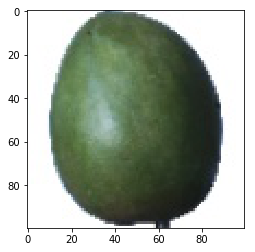

In [4]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

IMAGE_SIZE = [100, 100]

epochs = 5
batch_size = 32

train_path = '../large_files/fruits-360-small/Training'
test_path = '../large_files/fruits-360-small/Test'

# извлекаем все изображения, путь к которым подпадает под данный паттерн
image_files = glob(train_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

# пригодится, чтобы быстро определить количество целевых классов
folders = glob(train_path + '/*')

# отобразим случайно выбранное изображение из обучающей выборки
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

Архитектура VGG16 (Visual Geometry Group) довольно проста: куча свёрточных слоёв, у которых размер фильтра 3 на 3, чередующихся с пулинг слоем, целью которого постепенно уменьшать размер изображения, что позволяет постепенно извлекать все более и более сложные признаки; также количество фильтров растет по мере продвижения по архитектуре, что позволяет извлекать больше признаков из изображений (их еще называют feature maps).

In [5]:
# создаём модель VGG, что одновременно загружает предобученные веса
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# мы не будем обучать сверточные слои у VGG
for layer in vgg.layers:
    layer.trainable = False
    
# тут начинается уже наша верхушка
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# создаем модель
model = Model(inputs=vgg.input, outputs=prediction)

# более подробное описание архитектуры
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 89s 2us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)     

In [6]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

gen = ImageDataGenerator(
  # правила, по которым мы позволим данному генератору изменять наши изображения
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  # данная функция меняет порядок каналов в цветном изображении
  # VGG обучалась в другой библиотеке, где использовались BGR каналы, это мы и хотим поменять
  # также эта функция вычисляет среднее значение пикселей в изображении и вычитает его из каждого
  preprocessing_function=preprocess_input
)

# get label mapping for confusion matrix plot later
# test_gen = gen.flow_from_directory(test_path, target_size=IMAGE_SIZE)
# print(test_gen.class_indices)
# labels = [None] * len(test_gen.class_indices)
# for k, v in test_gen.class_indices.items():
#     labels[v] = k

Found 1285 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


We want to check if the data is preprocessed properly with generator.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -58.023922 max: 151.061


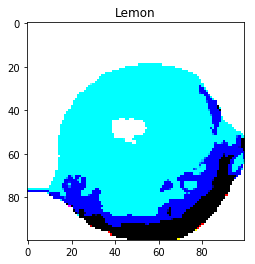

In [10]:
# проверяем работу генератора
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [21]:
# создаем генераторы для каждой выборки
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
test_generator = gen.flow_from_directory(
  test_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


# обучаем модель
r = model.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(test_image_files) // batch_size,
)

Found 3827 images belonging to 8 classes.
Found 1285 images belonging to 8 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
119/119 [==============================] - 516s 4s/step - loss: 3.0434 - accuracy: 0.7971 - val_loss: 0.5414 - val_accuracy: 0.8664
Epoch 2/5
119/119 [==============================] - 471s 4s/step - loss: 2.0933 - accuracy: 0.8680 - val_loss: 2.5185 - val_accuracy: 0.8651
Epoch 3/5
119/119 [==============================] - 508s 4s/step - loss: 2.1142 - accuracy: 0.8685 - val_loss: 0.5037 - val_accuracy: 0.8699
Epoch 4/5
119/119 [==============================] - 513s 4s/step - loss: 2.0669 - accuracy: 0.8705 - val_loss: 1.0074 - val_accuracy: 0.8643
Epoch 5/5
119/119 [==============================] - 588s 5s/step - loss: 2.0744 - accuracy: 0.8707 - val_loss: 2.5185 - val_accuracy: 0.8723


Поскольку наши данные не в формате .csv, то нам придется написать свою функцию, чтобы получить confusion matrix нашей модели.

In [22]:
def get_confusion_matrix(data_path, N):
    predictions = []
    targets = []
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
test_cm = get_confusion_matrix(test_path, len(test_image_files))
print(test_cm)

Generating confusion matrix 3827
Found 3827 images belonging to 8 classes.
50
[[480   0   0   0   0   0   0   0]
 [  0 424   0   0   0   2   0   1]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [392   0   1   1   0   0   0  98]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Generating confusion matrix 1285
Found 1285 images belonging to 8 classes.
[[160   0   0   0   0   0   0   0]
 [  0 141   0   0   0   2   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [115   0   7   0   0   0   0  42]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


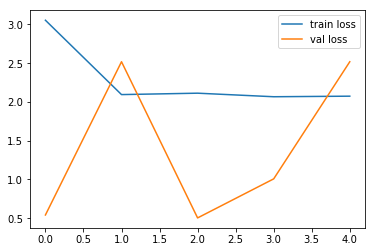

In [23]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

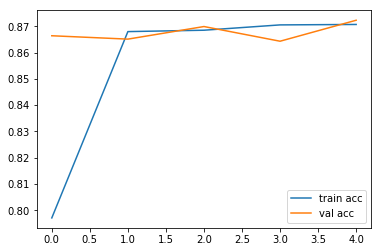

In [24]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

отобразим матрицу визуально

(8, -0.5)

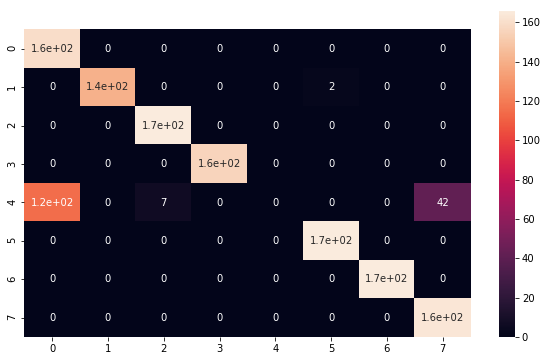

In [28]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(test_cm,annot=True)
plt.ylim(len(folders), -0.5)